In [1]:
import os
import requests 
from shutil import unpack_archive
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
import transformers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [2]:
data_df = pd.read_csv('data/DoAScoring-TitlesMultilabelDataset.csv',delimiter=";",encoding_errors="ignore")


def labels(title):
    return [title["role_flag"],title["focus_area_flag"],title["region_flag"],title["agency_flag"]]
Y = data_df.apply(labels,axis=1)

X=data_df["title"].astype(str).str.strip()
#split data into training and validation data
data_train, data_test, labels_train, labels_test = train_test_split(X, Y, test_size=0.1, random_state=42)
data_train, data_val, labels_train, labels_val = train_test_split(data_train, labels_train, test_size=0.2, random_state=42)


print("train data",data_train.shape)
print("val data",data_val.shape)
print("test data",data_test.shape)
print("train labels",labels_train.shape)
print("val labels",labels_val.shape)
print("test labels",labels_test.shape)

train data (540,)
val data (135,)
test data (75,)
train labels (540,)
val labels (135,)
test labels (75,)


In [3]:
def graph_training_results (history):
    plt.rcParams['figure.figsize'] = [20, 5]
    f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
    ax1.set_title('Losses')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.legend(loc="upper right")
    ax1.grid()
    ax1.plot(history.history['loss'], label='Training loss')
    ax1.plot(history.history['val_loss'], label='Validation loss')
    ax1.legend()
    
    ax2.set_title('Accuracy')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('acc')
    ax2.legend(loc="upper right")
    ax2.grid()
    ax2.plot(history.history['accuracy'], label='Training accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation accuracy')
    ax2.legend()
    
    plt.show()

In [4]:
input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(
    "https://kaggle.com/models/tensorflow/bert/TensorFlow2/en-cased-preprocess/3")
encoder_inputs = preprocessor(input)
encoder = hub.KerasLayer(
    "https://www.kaggle.com/models/tensorflow/bert/TensorFlow2/en-cased-l-12-h-768-a-12/4",
    trainable=False)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]      # [batch_size, 768].
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768].

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['input_1[0][0]']                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

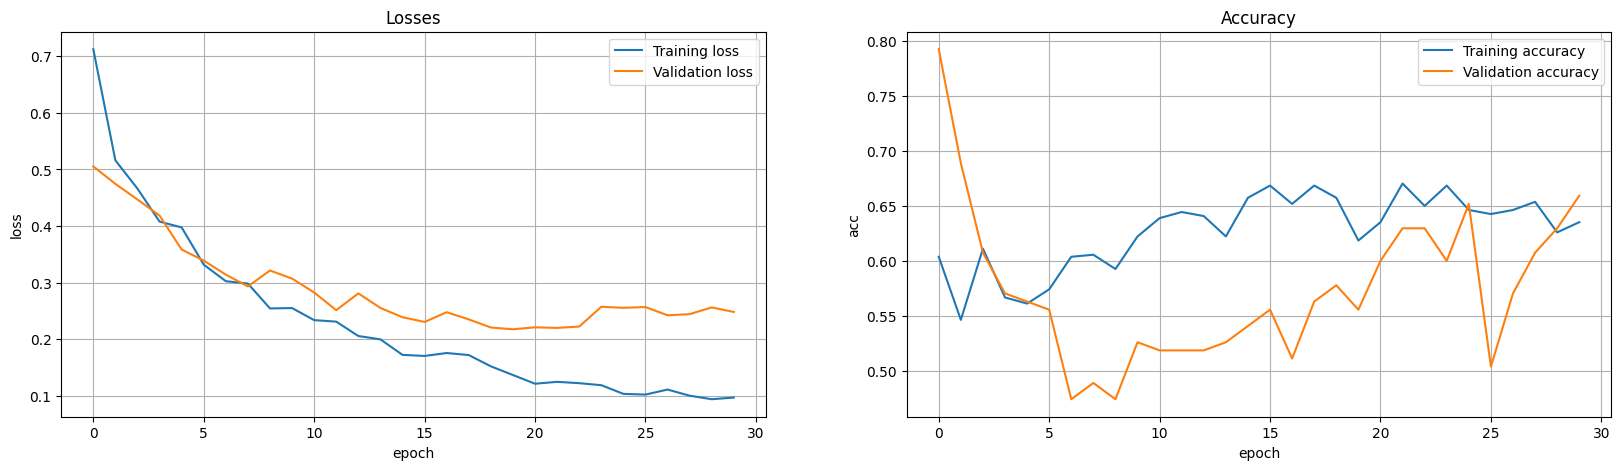

In [5]:
fii = tf.keras.layers.Conv1D(64,3,3)(sequence_output)
fii = tf.keras.layers.MaxPooling1D(padding='same')(fii)
fii = tf.keras.layers.Conv1D(32,3,3)(fii)
fii = tf.keras.layers.MaxPooling1D(padding='same')(fii)
fii = tf.keras.layers.BatchNormalization()(fii)
fii = tf.keras.layers.Dropout(0.8)(fii)
fii = tf.keras.layers.Flatten()(fii)
fii = tf.keras.layers.Dense(8, activation='relu')(fii)
fii=tf.keras.layers.Dense(4, activation='sigmoid',name='output')(fii)

model = tf.keras.Model(inputs=[input],outputs=[fii])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=["accuracy"])
model.summary()
history_batch30= model.fit(data_train.tolist(), labels_train.tolist(), 
                    validation_data=(data_val.tolist(),labels_val.tolist()),
                    epochs=30,
                    batch_size=30) 


Epoch 1/30
3/3 [==============================] - 77s 24s/step - loss: 0.0928 - accuracy: 0.6185 - val_loss: 0.2463 - val_accuracy: 0.6296
Epoch 2/30
3/3 [==============================] - 74s 23s/step - loss: 0.0721 - accuracy: 0.6407 - val_loss: 0.2464 - val_accuracy: 0.6074
Epoch 3/30
3/3 [==============================] - 74s 23s/step - loss: 0.0781 - accuracy: 0.6519 - val_loss: 0.2482 - val_accuracy: 0.5778
Epoch 4/30
3/3 [==============================] - 74s 23s/step - loss: 0.0751 - accuracy: 0.6167 - val_loss: 0.2503 - val_accuracy: 0.5556
Epoch 5/30
3/3 [==============================] - 74s 23s/step - loss: 0.0748 - accuracy: 0.6000 - val_loss: 0.2511 - val_accuracy: 0.5407
Epoch 6/30
3/3 [==============================] - 74s 23s/step - loss: 0.0796 - accuracy: 0.6333 - val_loss: 0.2496 - val_accuracy: 0.5259
Epoch 7/30
3/3 [==============================] - 74s 23s/step - loss: 0.0794 - accuracy: 0.5907 - val_loss: 0.2467 - val_accuracy: 0.5333
Epoch 8/30
3/3 [===========

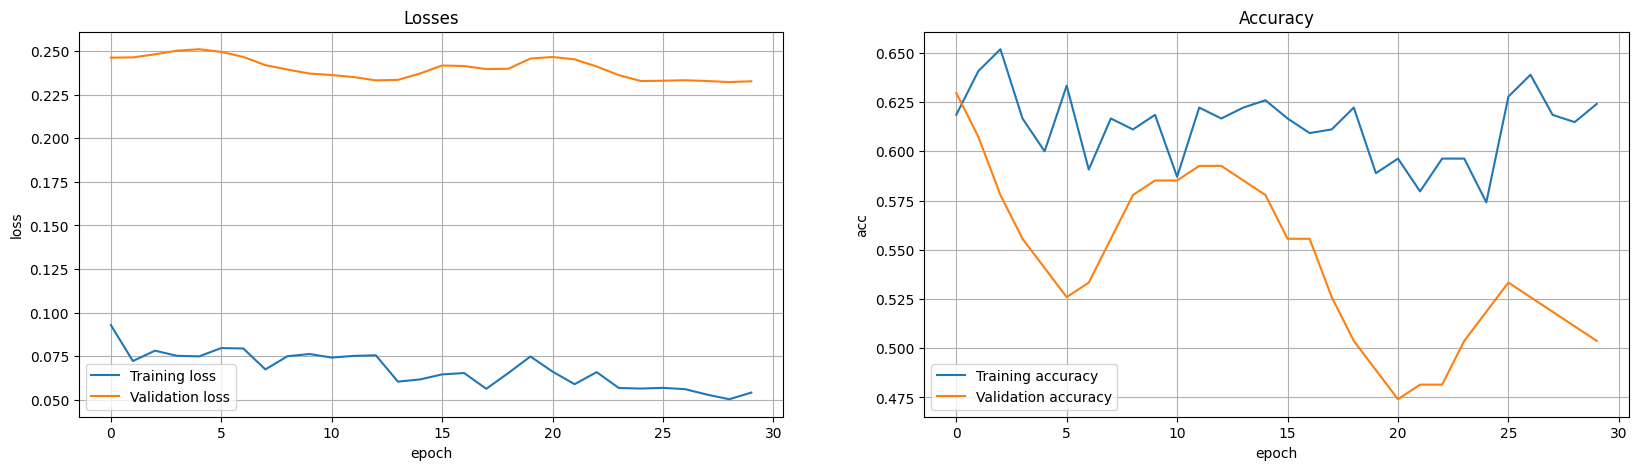

In [6]:
history_batch256 = model.fit(data_train.tolist(), labels_train.tolist(), 
                    validation_data=(data_val.tolist(),labels_val.tolist()),
                    epochs=30,
                    batch_size=256)
graph_training_results(history_batch256) 



Epoch 1/30
1/1 [==============================] - 75s 75s/step - loss: 0.0644 - accuracy: 0.6241 - val_loss: 0.2333 - val_accuracy: 0.5037
Epoch 2/30
1/1 [==============================] - 73s 73s/step - loss: 0.0501 - accuracy: 0.6167 - val_loss: 0.2338 - val_accuracy: 0.5037
Epoch 3/30
1/1 [==============================] - 73s 73s/step - loss: 0.0526 - accuracy: 0.6019 - val_loss: 0.2344 - val_accuracy: 0.5037
Epoch 4/30
1/1 [==============================] - 73s 73s/step - loss: 0.0559 - accuracy: 0.6204 - val_loss: 0.2351 - val_accuracy: 0.5037
Epoch 5/30
1/1 [==============================] - 73s 73s/step - loss: 0.0521 - accuracy: 0.6037 - val_loss: 0.2357 - val_accuracy: 0.5037
Epoch 6/30
1/1 [==============================] - 73s 73s/step - loss: 0.0572 - accuracy: 0.5722 - val_loss: 0.2363 - val_accuracy: 0.5037
Epoch 7/30
1/1 [==============================] - 73s 73s/step - loss: 0.0557 - accuracy: 0.6278 - val_loss: 0.2368 - val_accuracy: 0.5037
Epoch 8/30
1/1 [===========

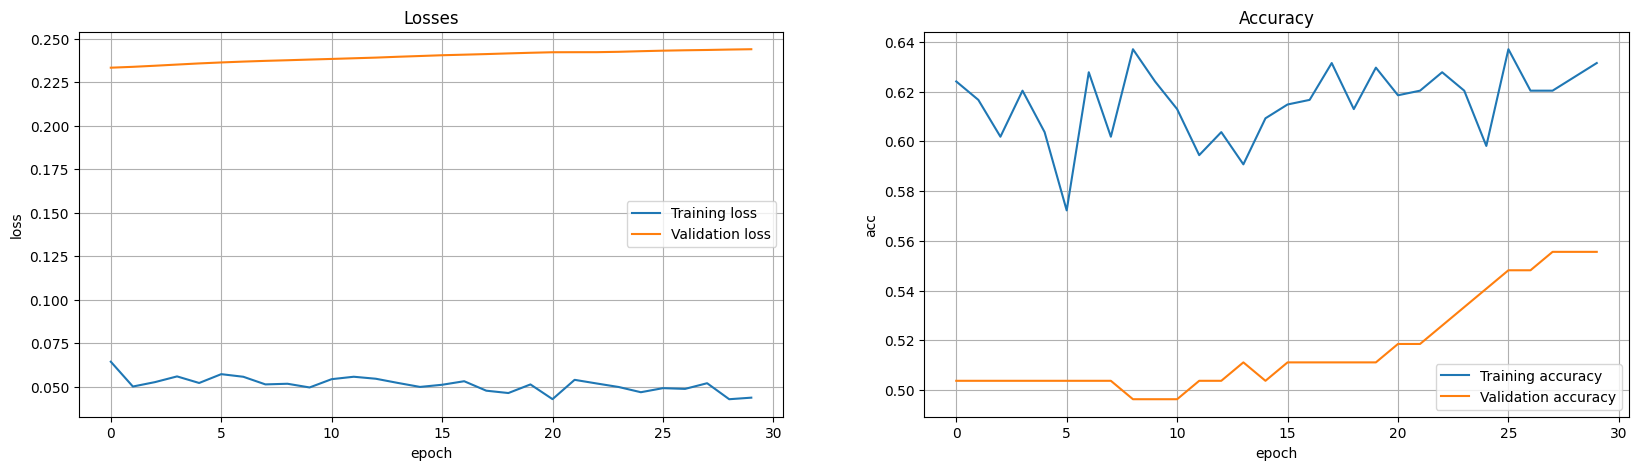

In [7]:
history_batch540 = model.fit(data_train.tolist(), labels_train.tolist(), 
                    validation_data=(data_val.tolist(),labels_val.tolist()),
                    epochs=30,
                    batch_size=540) 


Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['input_1[0][0]']                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                               

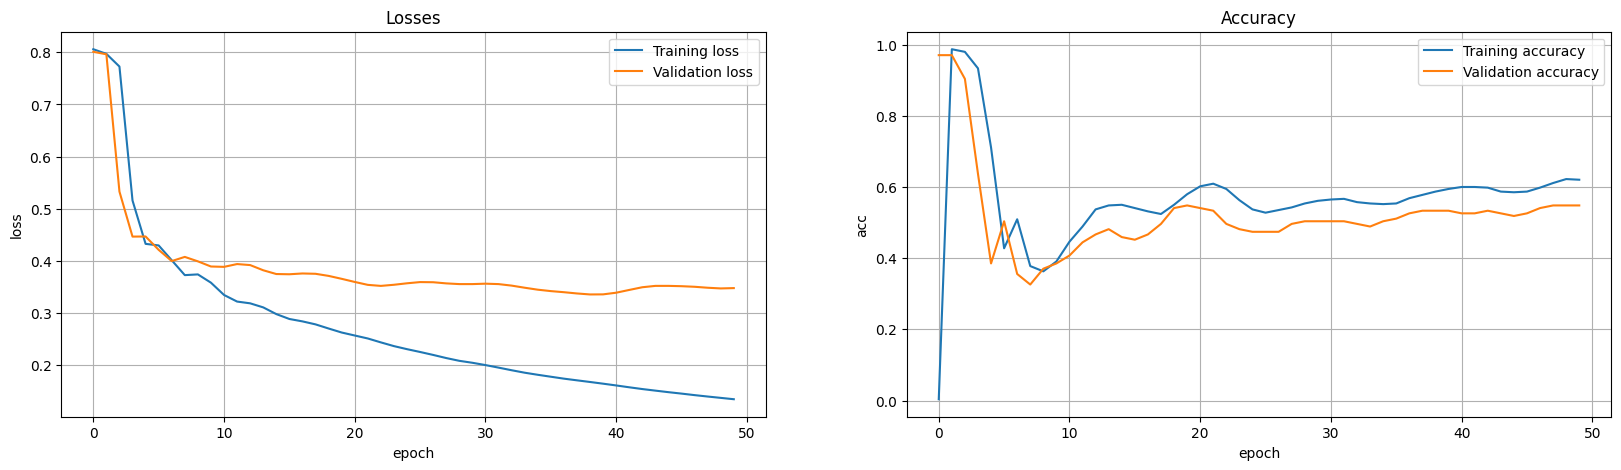

In [26]:
fii = tf.keras.layers.Flatten()(sequence_output)
fii = tf.keras.layers.Dense(50, activation='relu')(fii)
fii = tf.keras.layers.Dense(30, activation='relu')(fii)
fii = tf.keras.layers.Dense(8, activation='relu')(fii)
fii=tf.keras.layers.Dense(4, activation='sigmoid',name='output')(fii)

model_dense = tf.keras.Model(inputs=[input],outputs=[fii])

model_dense.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=["accuracy"])
model_dense.summary()
history_dense = model_dense.fit(data_train.tolist(), labels_train.tolist(), 
                    validation_data=(data_val.tolist(),labels_val.tolist()),
                    epochs=50,
                    batch_size=540)
graph_training_results(history_dense) 


Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['input_1[0][0]']                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                               

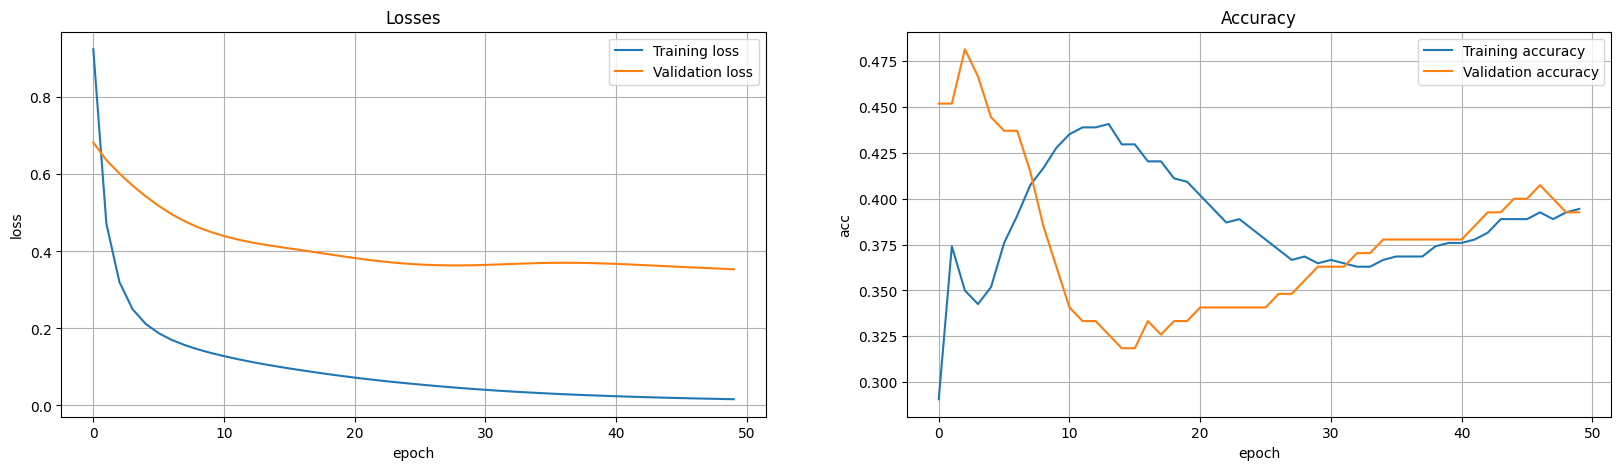

In [30]:
fii = tf.keras.layers.Conv1D(64,3,3)(sequence_output)
fii = tf.keras.layers.MaxPooling1D(padding='same')(fii)
fii = tf.keras.layers.Conv1D(32,3,3)(fii)
fii = tf.keras.layers.MaxPooling1D(padding='same')(fii)
fii = tf.keras.layers.BatchNormalization()(fii)
fii = tf.keras.layers.Flatten()(fii)
fii=tf.keras.layers.Dense(4, activation='sigmoid',name='output')(fii)

model_cnn = tf.keras.Model(inputs=[input],outputs=[fii])

model_cnn.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=["accuracy"])
model_cnn.summary()
history_cnn = model_cnn.fit(data_train.tolist(), labels_train.tolist(), 
                    validation_data=(data_val.tolist(),labels_val.tolist()),
                    epochs=50,
                    batch_size=540)
graph_training_results(history_cnn) 


Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['input_1[0][0]']                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                               

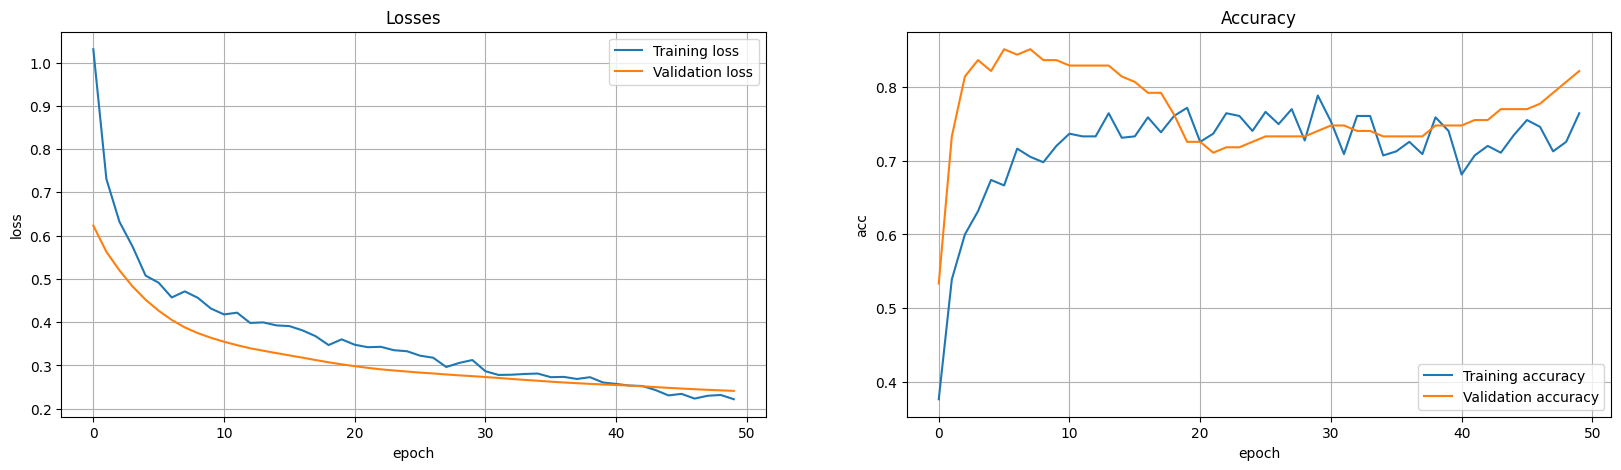

In [23]:
fii = tf.keras.layers.Conv1D(64,3,3)(sequence_output)
fii = tf.keras.layers.MaxPooling1D(padding='same')(fii)
fii = tf.keras.layers.Conv1D(32,3,3)(fii)
fii = tf.keras.layers.MaxPooling1D(padding='same')(fii)
fii = tf.keras.layers.BatchNormalization()(fii)
fii = tf.keras.layers.Dropout(0.8)(fii)
fii = tf.keras.layers.Flatten()(fii)
fii = tf.keras.layers.Dense(8, activation='relu')(fii)
fii=tf.keras.layers.Dense(4, activation='sigmoid',name='output')(fii)

model_540 = tf.keras.Model(inputs=[input],outputs=[fii])
model_540.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=["accuracy"])data_test_list = data_test.tolist()
labels_test_list = labels_test.tolist()
pred = model_540.predict(data_test_list)
predictions_list = []
for index,res in enumerate(pred):
    prediction = []
    for i in res:
        prediction.append(round(i))
    predictions_list.append(prediction)
    #print(data_test_list[index])
    #print(prediction)
acc = 0
for index,prediction in enumerate(predictions_list):
    print(data_test_list[index])
    print("correct result",labels_test_list[index])
    print("model prediction",prediction)
    if(prediction == labels_test_list[index]):
        acc +=1
print((acc/len(predictions_list))*100)
model_540.summary()

history_540 = model_540.fit(data_train.tolist(), labels_train.tolist(), 
                    validation_data=(data_val.tolist(),labels_val.tolist()),
                    epochs=50,
                    batch_size=540)
graph_training_results(history_540) 

In [44]:
data_test_list = data_test.tolist()
labels_test_list = labels_test.tolist()
pred = model_dense.predict(data_test_list)
predictions_list = []
for index,res in enumerate(pred):
    prediction = []
    for i in res:
        prediction.append(round(i))
    predictions_list.append(prediction)
    #print(data_test_list[index])
    #print(prediction)
acc = 0
for index,prediction in enumerate(predictions_list):
    print(data_test_list[index])
    print("correct result",labels_test_list[index])
    print("model prediction",prediction)
    if(prediction == labels_test_list[index]):
        acc +=1
print((acc/len(predictions_list))*100)

3/3 [==============================] - 13s 4s/step
Programme Analyst Pacific Digital Economy Programme
correct result [1, 1, 0, 0]
model prediction [1, 1, 0, 0]
Interpreter/Associate Translation Officer (English-Tigrinya-Amharic) at UNHCR Rwanda
correct result [1, 1, 1, 1]
model prediction [1, 1, 1, 1]
Communication and Reporting Assistant for UNDP in Afghanistan
correct result [1, 0, 1, 1]
model prediction [1, 1, 1, 1]
External Communications Officer
correct result [1, 1, 0, 0]
model prediction [1, 1, 0, 0]
HIV Specialist - Vientiane, Lao PDR
correct result [1, 1, 1, 0]
model prediction [1, 0, 1, 1]
Supply and Logistics Assistant (UNICEF)
correct result [1, 1, 0, 1]
model prediction [1, 1, 0, 1]
OCHA Information Management Associate
correct result [1, 1, 0, 1]
model prediction [1, 1, 0, 1]
Communications and Visibility Officer in Harare, Zimbabwe
correct result [1, 1, 1, 0]
model prediction [1, 1, 1, 0]
Programme Coordination Assistant (UNEP)
correct result [1, 0, 0, 1]
model predicti

In [45]:
data_test_list = data_test.tolist()
labels_test_list = labels_test.tolist()
pred = model_cnn.predict(data_test_list)
predictions_list = []
for index,res in enumerate(pred):
    prediction = []
    for i in res:
        prediction.append(round(i))
    predictions_list.append(prediction)
    #print(data_test_list[index])
    #print(prediction)
acc = 0
for index,prediction in enumerate(predictions_list):
    print(data_test_list[index])
    print("correct result",labels_test_list[index])
    print("model prediction",prediction)
    if(prediction == labels_test_list[index]):
        acc +=1
print((acc/len(predictions_list))*100)

3/3 [==============================] - 14s 4s/step
Programme Analyst Pacific Digital Economy Programme
correct result [1, 1, 0, 0]
model prediction [1, 0, 0, 0]
Interpreter/Associate Translation Officer (English-Tigrinya-Amharic) at UNHCR Rwanda
correct result [1, 1, 1, 1]
model prediction [1, 1, 1, 1]
Communication and Reporting Assistant for UNDP in Afghanistan
correct result [1, 0, 1, 1]
model prediction [1, 1, 1, 1]
External Communications Officer
correct result [1, 1, 0, 0]
model prediction [1, 1, 0, 0]
HIV Specialist - Vientiane, Lao PDR
correct result [1, 1, 1, 0]
model prediction [1, 0, 1, 1]
Supply and Logistics Assistant (UNICEF)
correct result [1, 1, 0, 1]
model prediction [1, 0, 0, 1]
OCHA Information Management Associate
correct result [1, 1, 0, 1]
model prediction [1, 0, 0, 1]
Communications and Visibility Officer in Harare, Zimbabwe
correct result [1, 1, 1, 0]
model prediction [1, 1, 1, 1]
Programme Coordination Assistant (UNEP)
correct result [1, 0, 0, 1]
model predicti

In [43]:
data_test_list = data_test.tolist()
labels_test_list = labels_test.tolist()
pred = model_540.predict(data_test_list)
predictions_list = []
for index,res in enumerate(pred):
    prediction = []
    for i in res:
        prediction.append(round(i))
    predictions_list.append(prediction)
    #print(data_test_list[index])
    #print(prediction)
acc = 0
for index,prediction in enumerate(predictions_list):
    print(data_test_list[index])
    print("correct result",labels_test_list[index])
    print("model prediction",prediction)
    if(prediction == labels_test_list[index]):
        acc +=1
print((acc/len(predictions_list))*100)

import sklearn.metrics as skm

#Create confusion matrix and normalizes it over predicted (columns)
print("[ true negative     false negative]")
print("[ false positive    true positive ]")
result = skm.multilabel_confusion_matrix(labels_test_list, predictions_list)
print("Rol confusion maxtrix")
print(result[0])
print("Enfoque confusion maxtrix")
print(result[1])
print("Region confusion maxtrix")
print(result[2])
print("Agencia confusion maxtrix")
print(result[3])
print( skm.classification_report(labels_test_list,predictions_list))

3/3 [==============================] - 13s 4s/step
Programme Analyst Pacific Digital Economy Programme
correct result [1, 1, 0, 0]
model prediction [1, 1, 1, 0]
Interpreter/Associate Translation Officer (English-Tigrinya-Amharic) at UNHCR Rwanda
correct result [1, 1, 1, 1]
model prediction [1, 1, 1, 1]
Communication and Reporting Assistant for UNDP in Afghanistan
correct result [1, 0, 1, 1]
model prediction [1, 1, 1, 1]
External Communications Officer
correct result [1, 1, 0, 0]
model prediction [1, 1, 0, 0]
HIV Specialist - Vientiane, Lao PDR
correct result [1, 1, 1, 0]
model prediction [1, 1, 1, 0]
Supply and Logistics Assistant (UNICEF)
correct result [1, 1, 0, 1]
model prediction [1, 1, 0, 1]
OCHA Information Management Associate
correct result [1, 1, 0, 1]
model prediction [1, 1, 0, 1]
Communications and Visibility Officer in Harare, Zimbabwe
correct result [1, 1, 1, 0]
model prediction [1, 1, 1, 0]
Programme Coordination Assistant (UNEP)
correct result [1, 0, 0, 1]
model predicti

In [48]:
model_540.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['input_1[0][0]']                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                               